# Daily Financial News for 6000+ Stocks
### Some Data Understanding an Preparation for Prediction of stockpricse by the Sentiment of Headlines
@author DHR <br>
@author BKN <br>
used Data in this Notebook: 'https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests'

## Requirements

In [1]:
#immport basic DataScience Modules
#!! for pip-modul-list to install @see requirements.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
#import basic topic modelling
import re
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import gensim

import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
#import basic visualization
from wordcloud import WordCloud, STOPWORDS
import nltk #tokenization
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import random

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#import basic api requirements
from polygon import RESTClient
import datetime
import time
from dotenv import load_dotenv
load_dotenv()

def unique(l):
    ## list of only the unique values from a given list
    x = np.array(l)
    return np.unique(x)

In [4]:
#Load Data
data = pd.read_csv('../data/raw_analyst_ratings.csv')
#colums: id,headline,url,publisher,date,stock

## Data Understanding

No Data Cleaning

In [34]:
#first Look
print(data.columns)
data.sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,headline,url,publisher,date,stock
309355,311089,Citigroup Raises PT on Cintas to $38,https://www.benzinga.com/analyst-ratings/price...,Juan Lopez,2011-12-21 00:00:00,CTAS
98968,99779,Top 4 Mid-Cap Stocks In The Chemicals-Major Di...,https://www.benzinga.com/trading-ideas/15/04/5...,Monica Gerson,2015-04-29 00:00:00,ASH
1321713,1328058,"Stocks Which Set New 52-Week Low Yesterday, Oc...",https://www.benzinga.com/trading-ideas/technic...,Benzinga Newsdesk,2018-10-10 11:01:06-04:00,VSAR
1188269,1194011,Seagate Drops Despite Earnings Beat,https://www.benzinga.com/news/earnings/13/01/3...,Sam Mattera,2013-01-28 00:00:00,STX
357309,359319,Credit Suisse Reinstates Outperform on Danaher...,https://www.benzinga.com/news/19/10/14587535/c...,Benzinga_Newsdesk,2019-10-14 00:00:00,DHR
1156186,1161844,Synnex shares are trading higher after the com...,https://www.benzinga.com/wiim/20/01/15104158/s...,Benzinga Newsdesk,2020-01-10 00:00:00,SNX
1342963,1349334,5 Biggest Price Target Changes For Tuesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2017-07-25 00:00:00,WERN


In [10]:
#statistics
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


observations: 1407328, features: 6 

unique headlines: 845770, unique stocks: 6204 



In [11]:
data.count()

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id           1407328
headline     1407328
url          1407328
publisher    1407328
date         1407328
stock        1407328
dtype: int64

In [40]:
stock = data.groupby("stock")
stock.sample()

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,headline,url,publisher,date,stock
300,300,Agilent Technologies Reports Q4 EPS $0.59 vs. ...,https://www.benzinga.com/news/earnings/16/11/8...,Paul Quintaro,2016-11-15 00:00:00,A
2080,2482,Can You Guess This Chart?,https://www.benzinga.com/general/16/10/8541035...,Benzinga News Desk,2016-10-07 00:00:00,AA
4223,4652,Mid-Day Market Update: Crude Oil Down 2%; Conv...,https://www.benzinga.com/news/18/11/12641208/m...,Lisa Levin,2018-11-06 00:00:00,AAC
4334,4763,"As Global Stocks Rally, Don't Forget These ETFs",https://www.benzinga.com/trading-ideas/long-id...,ETF Professor,2013-09-06 15:06:35-04:00,AADR
4440,4880,American Air CEO Says No Indication Of Stabili...,https://www.benzinga.com/news/20/03/15609605/a...,Benzinga Newsdesk,2020-03-19 00:00:00,AAL
...,...,...,...,...,...,...
1405504,1412025,Stocks That Hit 52-Week Lows On Wednesday,https://www.benzinga.com/news/20/03/15581474/s...,Benzinga Newsdesk,2020-03-18 11:37:49-04:00,ZTR
1406095,1412616,"Jefferies Maintains Buy on Zoetis, Lowers PT t...",https://www.benzinga.com/news/13/05/3623881/je...,Juan Lopez,2013-05-28 00:00:00,ZTS
1406219,1412740,RBC's 6 Small Cap Internet Companies To Watch,https://www.benzinga.com/analyst-ratings/analy...,TipRanks,2015-01-28 00:00:00,ZU
1406685,1413206,UPDATE: Zumiez Raises Q4 EPS Outlook from $0.4...,https://www.benzinga.com/news/16/01/6121481/up...,Paul Quintaro,2016-01-06 00:00:00,ZUMZ


In [13]:
stock.describe()

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id                                                              \
        count          mean         std        min         25%        50%   
stock                                                                       
A      1433.0  8.414222e+02  572.641862        0.0      358.00      716.0   
AA     2739.0  3.208664e+03  796.519728     1835.0     2519.50     3204.0   
AAC     162.0  4.681500e+03   46.909487     4601.0     4641.25     4681.5   
AADR      2.0  4.763500e+03    0.707107     4763.0     4763.25     4763.5   
AAL     460.0  5.005261e+03  133.349498     4765.0     4890.75     5005.5   
...       ...           ...         ...        ...         ...        ...   
ZTR      19.0  1.412033e+06    5.627314  1412024.0  1412028.50  1412033.0   
ZTS     623.0  1.412354e+06  179.988889  1412043.0  1412198.50  1412354.0   
ZU      161.0  1.412746e+06   46.620811  1412666.0  1412706.00  1412746.0   
ZUMZ    955.0  1.413304e+06  275.829053  1412827.0  1413065.50  1413304.0   
ZX       67.0  1.413815e+06   19.485037  1413782.0  1413798.50  1413815.0   

                              
              75%        max  
stock                         
A         1476.00     1834.0  
AA        3902.50     4600.0  
AAC       4721.75     4762.0  
AADR      4763.75     4764.0  
AAL       5120.25     5235.0  
...           ...        ...  
ZTR    1412037.50  1412042.0  
ZTS    1412509.50  1412665.0  
ZU     1412786.00  1412826.0  
ZUMZ   1413542.50  1413781.0  
ZX     1413831.50  1413848.0  

[6204 rows x 8 columns]

In [14]:
data['date']

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0          2020-06-05 10:30:54-04:00
1          2020-06-03 10:45:20-04:00
2          2020-05-26 04:30:07-04:00
3          2020-05-22 12:45:06-04:00
4          2020-05-22 11:38:59-04:00
                     ...            
1407323          2011-08-29 00:00:00
1407324          2011-06-22 00:00:00
1407325          2011-06-21 00:00:00
1407326          2011-06-21 00:00:00
1407327          2011-05-12 00:00:00
Name: date, Length: 1407328, dtype: object

### Data Visualization

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

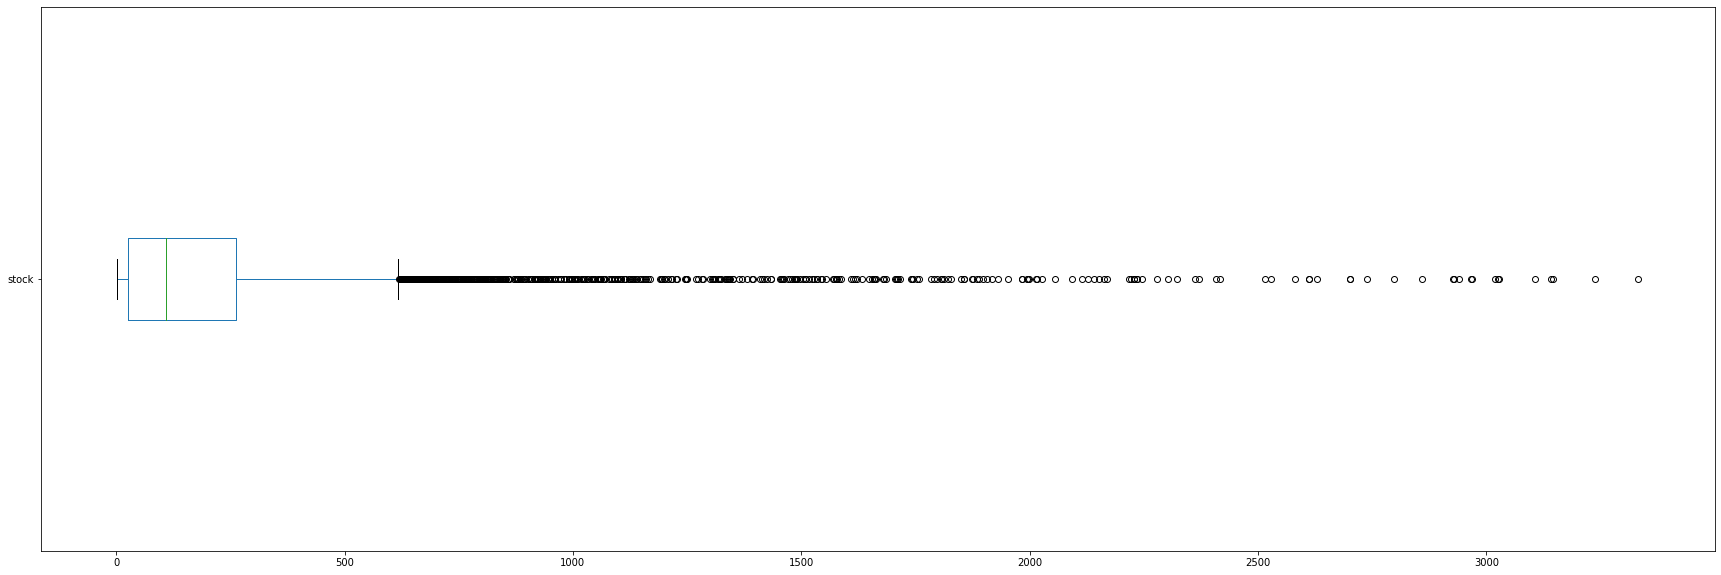

In [15]:
# BoxPlot of Stocks
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

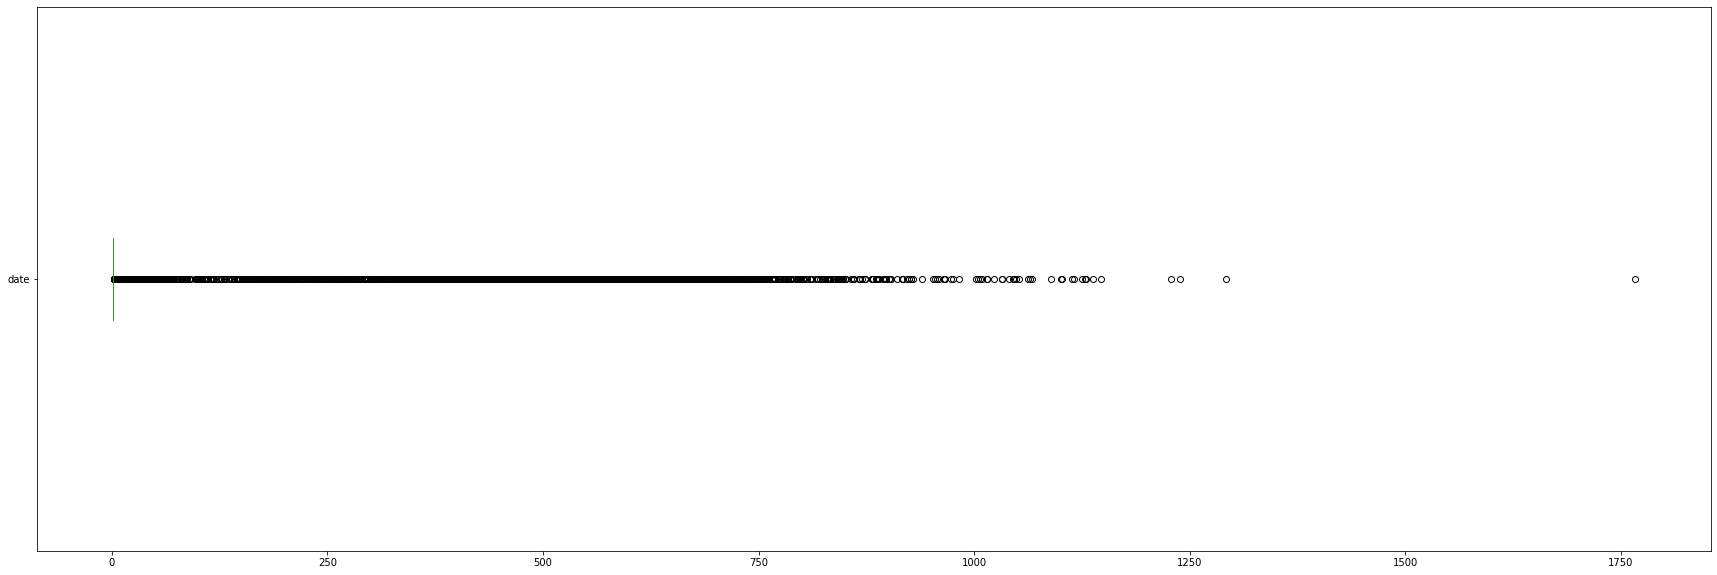

In [16]:
# BocPlot of Date
data['date'].value_counts().plot.box(vert=False, figsize=(30,10))

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


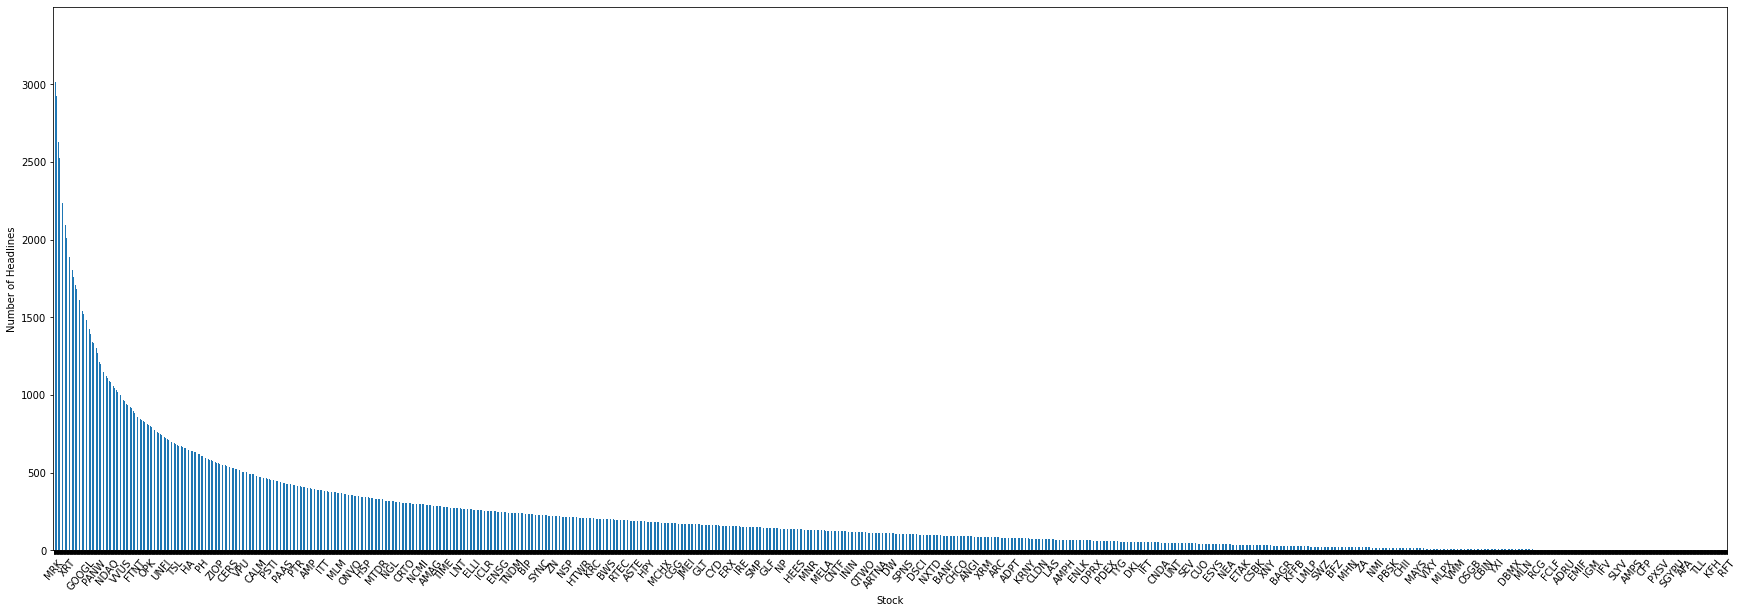

In [36]:
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False)[0:6204].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


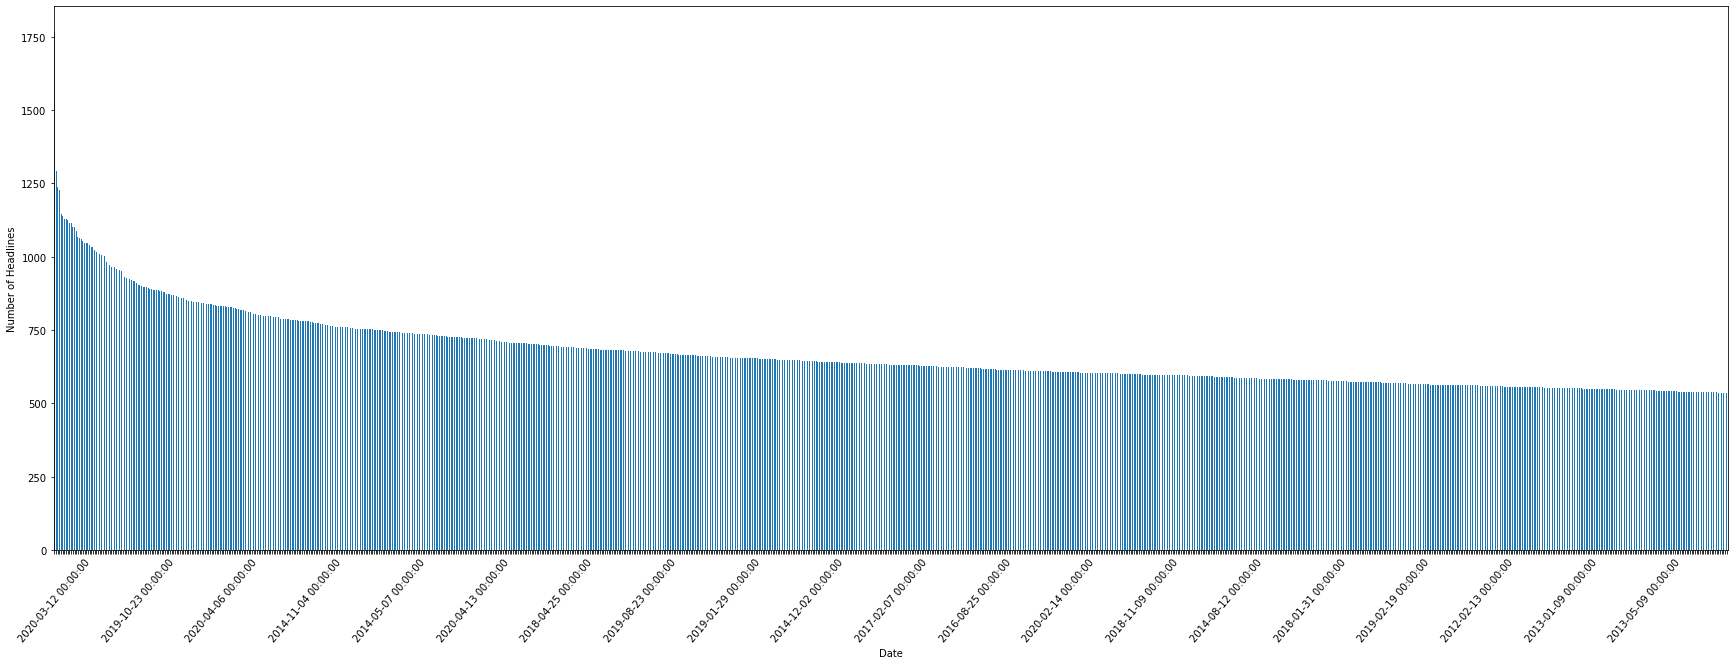

In [37]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False)[0:1000].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

In [19]:
date_withYear = data.assign(year = lambda dataframe: dataframe['date'].map(lambda date: date[0:4]))

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
print("Der Datensatz erstreckt sich über einen Datumsspanne vom "+ data['date'].min()[0:10] +" bis zum "+ data['date'].max()[0:10] +"\nDabei besteht der Datensatz aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich über einen Datumsspanne vom 2009-02-14 bis zum 2020-06-11
Dabei besteht der Datensatz aus 1407328 Einträgen


D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Number of Healines')

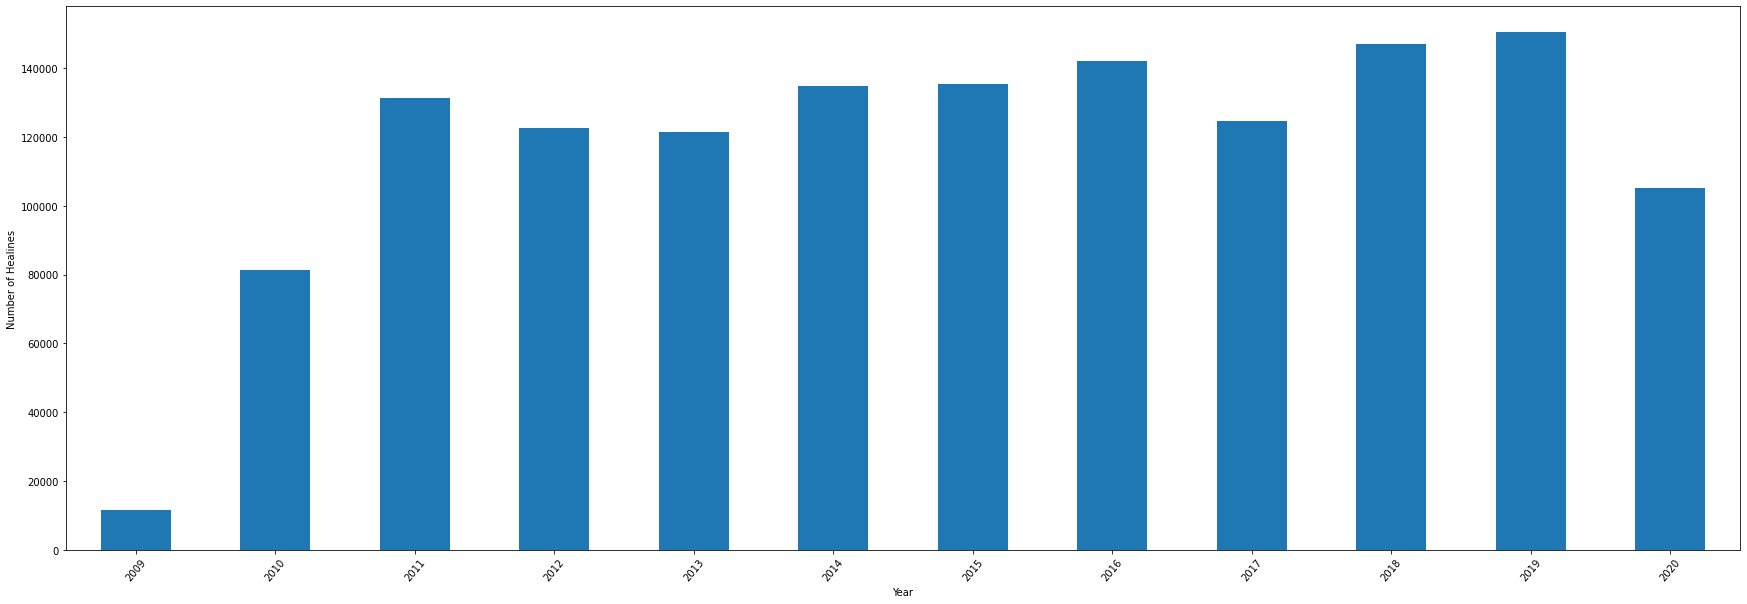

In [21]:
# Number of Date by Year
year = date_withYear.groupby("year")

plt.figure(figsize=(30,10))
year.size().plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Year")
plt.ylabel("Number of Healines")

In [45]:
import statistics

print(statistics.mean(year.size()))

117277.33333333333


D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Termdocument Matrix

# all headlines as String in List
docs = []
for headline in data.headline:
    docs.append(headline)
docs = docs[0:1000]

vec = CountVectorizer()
X = vec.fit_transform(docs)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(df)

# !! TDM just useful for stemmend and removed Stopwords dataset

     00  000  014b  015b  01b  01m  02b  02m  03  03b  ...  yo  you  young  \
0     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
1     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
2     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
3     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
4     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
..   ..  ...   ...   ...  ...  ...  ...  ...  ..  ...  ...  ..  ...    ...   
995   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
996   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
997   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
998   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
999   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   

     your  yoy  yum  zacks  zoll  zone  zoom  
0       0    0  

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Wordclouds before Data Cleaning

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


WorldCloud over all Stocks, Top 50 Words:


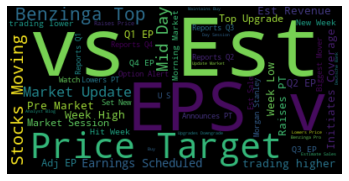

In [23]:
# Wordcloud for all Headlines

#combine all headlines to one text
text = " ".join(headline for headline in data.headline)
maxWords = 50
#wordcloud
#!! No Stopword removal
# stopwords = STOPWORDS
# stopwords.update(["Benzinga", "Stocks", "vs", "Est", "EPS"])
wordcloud = WordCloud(max_words=maxWords).generate(text)

#plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud.png")

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


WorldCloud for Random Stock: DIN, Top 50 Words:


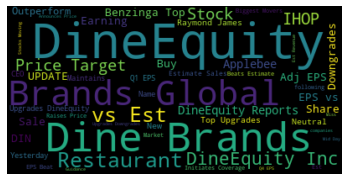

In [24]:
# Wordcloud for one Stock

#combine all headlines of one Stock
stockFilter = random.choice(unique(data['stock']))
maxWords = 50
text_SpecificStock = " ".join(headline for headline in data[data["stock"]==stockFilter].headline)

#wordcloud
#!! No Stopword removal
wordcloud = WordCloud(max_words=maxWords).generate(text_SpecificStock)

#plot
print("WorldCloud for Random Stock: " + stockFilter + ", Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_stock-"+ stockFilter +".png")

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


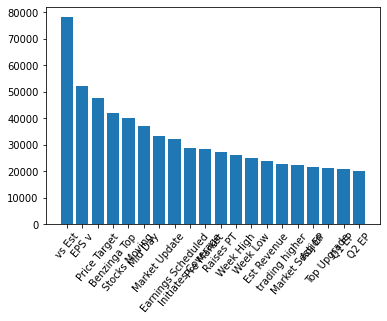

In [25]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

#### Topic Modelling before Data Cleaning

In [ ]:
# Topic Modelling with topicCount Topics
topicCount = 10

## Necessary Text Cleaning
# Remove punctuation
# data['headline_processed'] = \
# data['headline'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
# data['headline_processed'] = \
# data['headline_processed'].map(lambda x: x.lower())

# stop_words = stopwords.words('english')
# stop_words.extend(['bezinga', 'stock'])

## Necessary Tokenzisation of Sentences to Words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(simple_preprocess(str(sentence), deacc=True))
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) 
#              if word not in stop_words] for doc in texts]


headline = data.headline.values.tolist() #use headline_processed instead of headline for a little bit of DataCleaning
headline_words = list(sent_to_words(headline))
# remove stop words
# headline_words = remove_stopwords(headline_words)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(headline_words)
# Create Corpus
texts = headline_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
# The Real Topic Modelling
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=topicCount)
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualization of the Topic Modelling

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./app/results_ldavis_prepared_'+str(topicCount))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './app/results_ldavis_prepared_'+ str(topicCount) +'.html')
LDAvis_prepared

### Data Quality

In [6]:
# count all null values in the DataFrame
print("Anzahl von null Werten im gesamten DataFrame: "+str(data.isna().sum().sum()))

Anzahl von null Werten im gesamten DataFrame: 0


In [7]:
# count all dates without time, no need to format in isoFormat
print("Anzahl Zeitstempel ohne konkrete Uhrzeit: "+ str(data['date'].str.count('00:00:00').sum()))

Anzahl Zeitstempel ohne konkrete Uhrzeit: 1351341


In [8]:
# count duplicated
print("Anzahl Doppelten Einträgen: "+ str(data.duplicated().sum()))

Anzahl Doppelten Einträgen: 0


## Data Preparation

### Clean

In [9]:
# format datetime to date
data = data.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

# delete all rows older than 2years
data = data.drop(data[data.date < '2019-08-21'].index)


In [10]:
print("Der Datensatz erstreckt sich nun über einen Datumsspanne vom "+ data['date'].min() +" bis zum "+ data['date'].max() +"\nDabei besteht der Datensatz jetzt aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich nun über einen Datumsspanne vom 2019-08-21 bis zum 2020-06-11
Dabei besteht der Datensatz jetzt aus 164698 Einträgen


In [ ]:
# clean the Headlines


In [11]:
# clean the Stocks
# Remove Rows with Stocks that occur less than occ times
occ = 5
data = data[data.groupby('stock').stock.transform(len) > occ]

### Construct

#### API call to get StockPrices for all stocks that occur more than 10 times
used API : 'https://polygon.io/'
(need timeouts because of max 5 Api calls per Minute)

In [12]:
# List of Stock Ticker to call
stocks_unique = unique(data['stock'])
print("Es verbleiben "+str(len(stocks_unique))+" eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen")

Es verbleiben 3021 eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen


In [ ]:
# API call with TimeOut (5 per minute)
key = os.environ.get("POLYGON_IO_API_KEY")
results = []
apiCount = 0

for s in stocks_unique:
    # the API only response to 2years historical dates
    from_ = '2019-08-21'
    to =  '2020-12-31'

    #The API call
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(s, 1, "day", from_, to, unadjusted=False)
        # save the nessecary attributes of the JSON as List
        for result in resp.results:
            dt = datetime.datetime.fromtimestamp(result['t'] / 1000.0).isoformat()
            results.append([s, dt, result['o'], result['h'], result['l'], result['c']])
    apiCount+=1
    print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s)
    time.sleep(12)

#save the List-Data as DataFrame
stock_prices = pd.DataFrame(results, columns=['stock', 'date', 'open', 'high', 'low', 'close'])
#save the DataFrame as csv
stock_prices.to_csv('../data/raw_stock_prices.csv', encoding='utf-8', index=False)

In [ ]:
#get the API data from the csv to DataFrame
stock_prices = pd.read_csv('../data/raw_stock_prices.csv')

### Format

## Data Understanding: Visualization after Cleaning

#### Wordclouds after Data Cleaning

#### Topic Modelling after Data Cleaning

## Modeling